In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import to_hex
from matplotlib import ticker
import seaborn as sns
import joblib
from glob import glob

import sys
sys.path.append("../scripts")
from experiments import load_split, PROTECTED_ATTRIBUTES

from credit_pipeline import training, evaluate
from credit_pipeline.training import EBE # small fix to be able to load models
from credit_pipeline.training import ks_threshold
from credit_pipeline.explainability import *
%load_ext autoreload
%autoreload 2


2024-07-02 22:53:30.870754: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-02 22:53:30.909038: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 22:53:30.909059: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 22:53:30.910234: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-02 22:53:30.916565: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-02 22:53:30.917328: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
os.makedirs("explainability_data", exist_ok = True)

## config

In [3]:
dataset_name = "homecredit"
seed = 0
selected_fold = 0

In [4]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = load_split(
    dataset_name, selected_fold, seed
)

background_samples = 100
n_samples = 1000
X_background = X_train.sample(n = background_samples, random_state = seed)
X_sample = X_train.sample(n = n_samples, random_state = seed)

## Global Importances

In [40]:
def parallel_coordinates(
    df,
    columns,
    columns_ranges = None,
    columns_tick_format = None,
    columns_names = None,
    color_column = None,
    color_mapper = None,
    name_mapper = None,
    legend_order = None,
    title = None
):
    """
    Simple parallel coordinates to plot the projection results.
    """
    norm_df = df.copy() # dataframe will be normalized

    fig, axes = plt.subplots(len(columns)-1, 1, sharex=False, figsize=(5,10))

    if columns_ranges is None:
        columns_ranges = [None for _ in columns]
    if columns_tick_format is None:
        columns_tick_format = [lambda x : np.round(x, 1) for _ in columns]

    # Get min, max and range for each column
    # Normalize the data for each column
    min_max_range = {}
    for i, col in enumerate(columns):
        if columns_ranges[i] is None:
            col_max = df[col].max()
            col_min = df[col].min()
        else:
            col_max = columns_ranges[i][1]
            col_min = columns_ranges[i][0]

        min_max_range[col] = [col_min, col_max]
        col_range = col_max - col_min
        if col_range == 0:
            col_range = 1
        norm_df[col] = (df[col] - col_min) / col_range

    # Invert to plot first columns at the top
    x = list(range(len(columns)))[::-1]
    axx = axes[0].twiny()
    # Plot each row
    if color_column is None:
        for i, ax in enumerate(axes):
            for idx in norm_df.index:
                ax.plot(norm_df.loc[idx, columns], x, c = "#80b1d3", lw = 3)
        for idx in norm_df.index:
            axx.plot(norm_df.loc[idx, columns], x, c = "#80b1d3", lw = 3)
    else:
        color_values = norm_df[color_column].unique()
        colormap = plt.get_cmap("Paired")
        if color_column is not None and color_mapper is None:
            color_mapper = {color_value: colormap(i) for i, color_value in enumerate(color_values)}

        for ii, value in enumerate(color_values):
            df_value = norm_df[norm_df[color_column] == value]
            for i, ax in enumerate(axes[:-1]):
                for idx in df_value.index:
                    ax.plot(df_value.loc[idx, columns], x, alpha = 0.85, lw = 5, label = value, c = color_mapper[value])
            for idx in df_value.index:
                axx.plot(df_value.loc[idx, columns], x, alpha = 0.85, lw = 5, label = value, c = color_mapper[value])
    
    for i, ax in enumerate(axes):
        ax.set_ylim([x[i+1], x[i]])
        ax.set_xlim([-0.05, 1.05])
        xticks = ax.get_xticks()
        col_min = min_max_range[columns[i]][0]
        col_max = min_max_range[columns[i]][1]
        col_range = col_max - col_min
        format_ = columns_tick_format[i]
        ax.set_xticklabels([format_(yi * col_range  + col_min)  for yi in xticks], fontsize = 14)
    
    axes[0].set_xlim([-0.05, 1.05])

    for i, ax in enumerate(axes):
        #ax.yaxis.set_major_locator(ticker.FixedLocator([i+1]))
        ax.set_yticks([len(axes) - i])
        ax.set_yticklabels([columns_names[i]], fontsize = 18)

    axes[-1].set_yticks([0, 1])
    axes[-1].set_yticklabels([columns_names[-2], columns_names[-1]], fontsize = 18)

    # tick for right side of last axis
    axx.set_facecolor("none")
    xticks = axes[-1].get_xticks()
    col_min = min_max_range[columns[len(axes)]][0]
    col_max = min_max_range[columns[len(axes)]][1]
    col_range = col_max - col_min
    format_ = columns_tick_format[len(axes)]
    if format_ is None:
        axx.set_xticklabels([np.round((yi * col_range +  col_min), 1)  for yi in xticks], fontsize = 14)
    else:
        axx.set_xticklabels([format_(yi * col_range +  col_min)  for yi in xticks], fontsize = 14)
    #axx.xaxis.tick_top()
    #axx.set_axisbelow(True)
    #axx.set_xlim([-0.05, 1.05])
    #axx.spines['top'].set_visible(False)
    #axx.spines['bottom'].set_visible(False)

    for ax in list(axes) + [axx]:
        ax.set_facecolor("none")
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)


    
    if title:
        plt.suptitle(title, y = 1, fontsize = 20)
    # Remove space between subplots
    plt.subplots_adjust(hspace=0)

    if color_column is not None:
        handles = [
            mpatches.Patch(color=to_hex(color_mapper[value]), label=name_mapper[value]) for value in legend_order
        ]
        plt.legend(handles = handles, bbox_to_anchor=(1.3, 1), ncol = len(legend_order))

In [16]:
path = "../results/credit_models"
lr_features_importance = []
lgbm_features_importance = []
shap_lr_features_importance = []
shap_lgbm_features_importance = []


for fold in range(10):
    X_train, Y_train, X_val, Y_val, X_test, Y_test = load_split(
        dataset_name, fold, seed
    )
    model = joblib.load(f'{path}/{dataset_name}/{fold}/LogisticRegression.pkl')
    Y_score = model.predict_proba(X_val)[:, 1]
    threshold = ks_threshold(Y_val, Y_score)
    lr_features_importance.append(model[-1].coef_[0])
    explainer = ShapPipelineExplainer(
        model,
        X_train.sample(n = background_samples, random_state = seed),
        method_explain="pred",
        threshold = threshold
    )
    importances = explainer(X_train.sample(n = n_samples, random_state = seed))
    shap_lr_features_importance.append(importances.abs().mean().values)

    features_names = importances.columns.tolist()

    model = joblib.load(f'{path}/{dataset_name}/{fold}/LGBMClassifier.pkl')
    Y_score = model.predict_proba(X_val)[:, 1]
    threshold = ks_threshold(Y_val, Y_score)
    lgbm_features_importance.append(model[-1].feature_importances_ / sum(model[-1].feature_importances_))
    explainer = ShapPipelineExplainer(
        model,
        X_train.sample(n = background_samples, random_state = seed),
        method_explain="pred",
        threshold = threshold
    )
    importances = explainer(X_train.sample(n = n_samples, random_state = seed))
    shap_lgbm_features_importance.append(importances.abs().mean().values)


lr_features_importance = pd.DataFrame(
    np.array(lr_features_importance), columns = features_names
) 
lgbm_features_importance = pd.DataFrame(
    np.array(lgbm_features_importance), columns = features_names
)
shap_lr_features_importance = pd.DataFrame(
    np.array(shap_lr_features_importance), columns = features_names
)
shap_lgbm_features_importance = pd.DataFrame(
    np.array(shap_lgbm_features_importance), columns = features_names
)

PermutationExplainer explainer: 1001it [00:46, 16.95it/s]                                     
PermutationExplainer explainer: 1001it [01:37,  9.23it/s]                                     
PermutationExplainer explainer: 1001it [00:46, 16.71it/s]                                     
PermutationExplainer explainer: 1001it [00:58, 14.11it/s]                                     
PermutationExplainer explainer: 1001it [00:47, 16.64it/s]                                     
PermutationExplainer explainer: 1001it [00:58, 14.23it/s]                                     
PermutationExplainer explainer: 1001it [00:45, 17.07it/s]                                     
PermutationExplainer explainer: 1001it [01:46,  8.53it/s]                                     
PermutationExplainer explainer: 1001it [00:47, 16.57it/s]                                     
PermutationExplainer explainer: 1001it [01:58,  7.71it/s]                                     
PermutationExplainer explainer: 1001it [00:45, 17.

In [9]:
def filter_importance_features(df_importance):
    """Get the median (abs) importance of each feature and select the 10 featuers with highest median importance."""
    importance_values = df_importance.values
    median_importance = np.median(np.abs(importance_values), axis=0)
    sorted_idx = np.argsort(median_importance)[::-1][:10]
    features = df_importance.columns.tolist()
    features_sorted = np.array(features)[sorted_idx]
    return features_sorted

In [21]:
def plot_pc_importances(df_importance, title = "", filename = "plot"):
    features = filter_importance_features(df_importance).tolist()
    n_f = len(features)
    imp_range = [
        df_importance[features].values.min(), df_importance[features].values.max()
    ]
    tick_format = lambda x : f"{x:.2f}"
    parallel_coordinates(
        df_importance,
        features,
        columns_ranges = [imp_range for _ in range(n_f)],
        columns_tick_format = [tick_format for _ in range(n_f)],
        columns_names = features,
        title = title
    )
    plt.savefig(f"explainability_data/{filename}.pdf", dpi = 300)

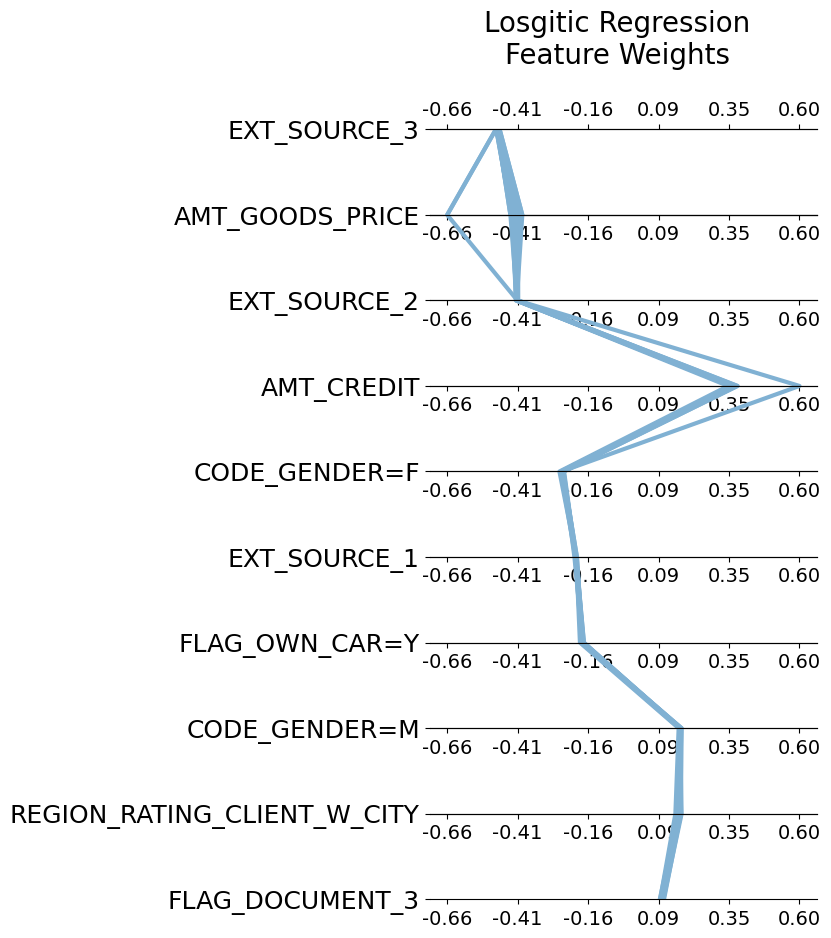

In [41]:
plot_pc_importances(lr_features_importance, "Losgitic Regression\nFeature Weights", "lr_importances")

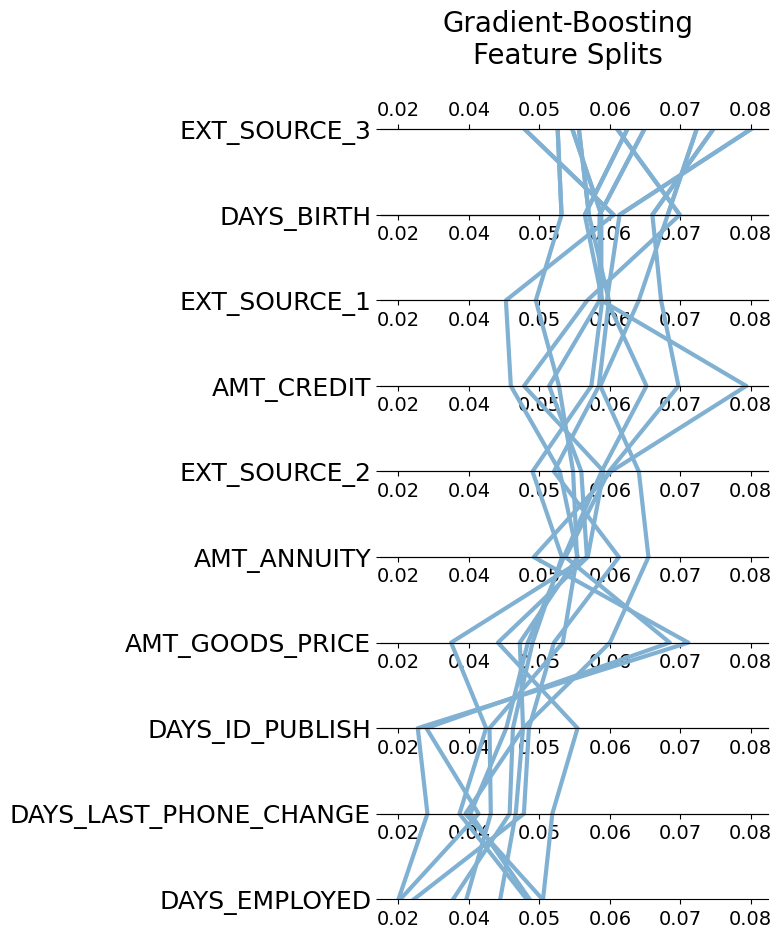

In [42]:
plot_pc_importances(lgbm_features_importance, "Gradient-Boosting\nFeature Splits", "lgbm_splits")

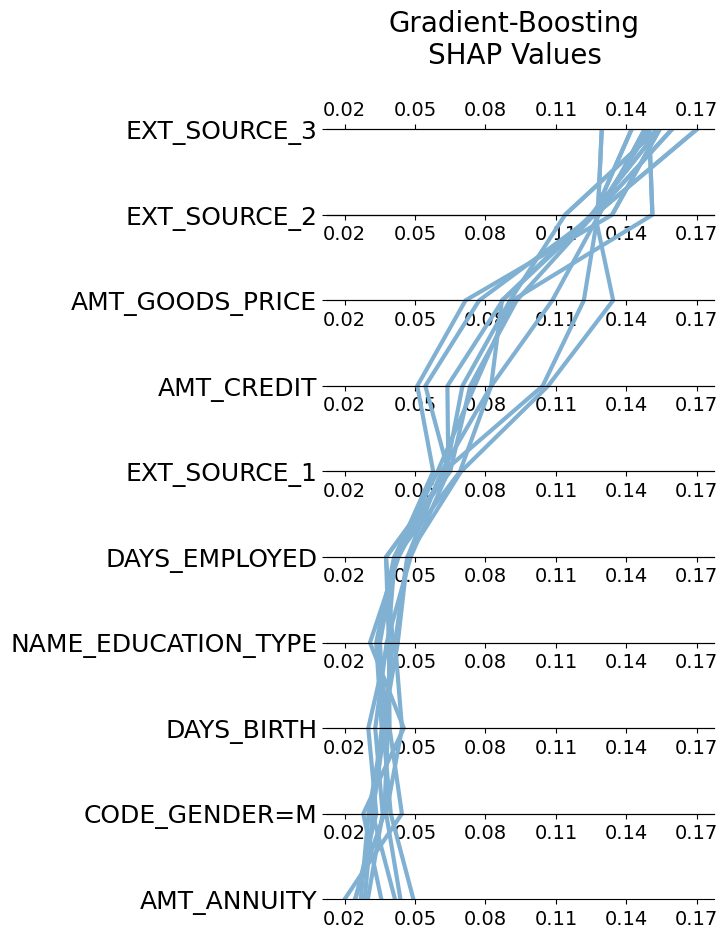

In [43]:
plot_pc_importances(shap_lgbm_features_importance, "Gradient-Boosting\nSHAP Values", "lgbm_shap")

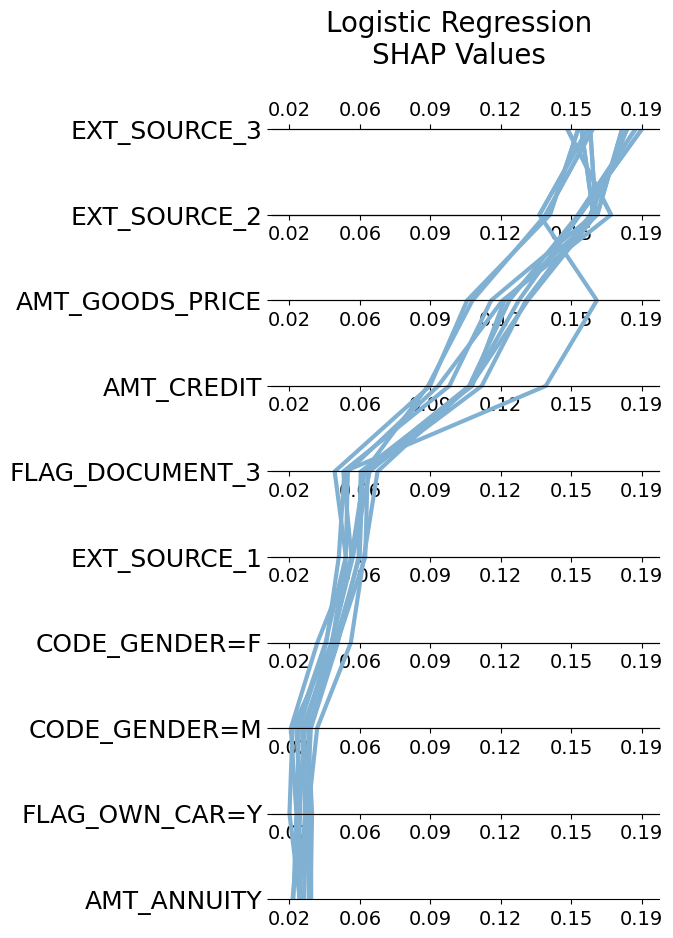

In [44]:
plot_pc_importances(shap_lr_features_importance, "Logistic Regression\nSHAP Values", "lr_shap")

## PDP

In [5]:
model_list = [
    joblib.load(f'../results/credit_models/{dataset_name}/{selected_fold}/{model_name}.pkl')
    for model_name in ["LogisticRegression", "MLPClassifier", "RandomForestClassifier", "LGBMClassifier"]
]

In [7]:
def plot_pdp(model_list, X, selected_feature):
    fig, axs = plt.subplots(nrows = 1, ncols = len(model_list), figsize = (15, 4))
    better_names = {
        "LogisticRegression": "Logistic Regression",
        "MLPClassifier": "Neural Network",
        "RandomForestClassifier": "Random Forest",
        "LGBMClassifier": "Gradient-Boosting"
    }
    for i, model in enumerate(model_list):
        explainer = PartialDependencePipeline(model)
        pdp = explainer(X, selected_feature)
        axs[i].plot(pdp["values"], pdp["prediction"])
        axs[i].set_title(better_names[model[-1].__class__.__name__])
        axs[i].set_xlabel(selected_feature)
        axs[i].set_ylabel("Probability of Default")

        for decile in pdp["deciles"]:
            axs[i].axvline(decile, ymin = 0, ymax = 0.05, color = "#606060", alpha = 0.9)

        
        axs[i].set_xscale("log")
        # select 3 ticks in pdp["deciles"]
        step = len(pdp["deciles"]) // 3
        axs[i].set_xticks(pdp["deciles"][::step], ["{:.1E}".format(x) for x in pdp["deciles"][::step]])

    
    plt.suptitle(f"Partial Dependence Plot for {selected_feature}", fontsize = 16)
    plt.tight_layout()

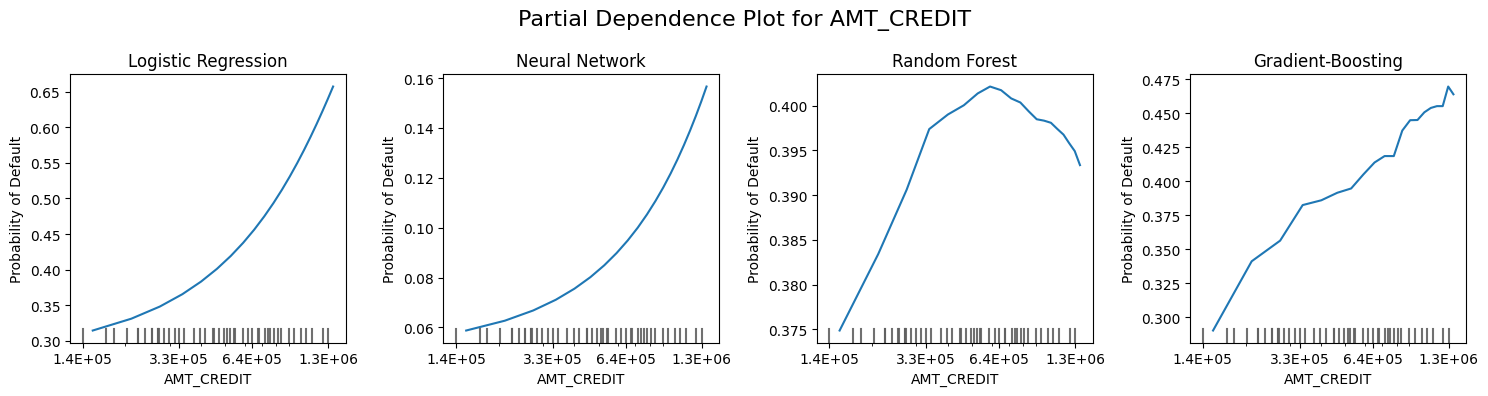

In [8]:
plot_pdp(model_list, X_sample, "AMT_CREDIT")
plt.savefig("explainability_data/pdp_credit.pdf", dpi = 300)

## ICE

In [9]:
def plot_ice(model_list, X, selected_feature):
    fig, axs = plt.subplots(nrows = 1, ncols = len(model_list), figsize = (15, 4))

    better_names = {
        "LogisticRegression": "Logistic Regression",
        "MLPClassifier": "Neural Network",
        "RandomForestClassifier": "Random Forest",
        "LGBMClassifier": "Gradient-Boosting"
    }

    
    for i, model in enumerate(model_list):
        explainer = PartialDependencePipeline(model, kind = "individual")
        pdp = explainer(X, selected_feature)
        # reset to all lines start at 0
        pdp["prediction"] = pdp["prediction"] - pdp["prediction"][:, 0][:, np.newaxis]
        for j in range(X.shape[0]):
            c = "#80b1d3"
            axs[i].plot(pdp["values"], pdp["prediction"][j, :], c, alpha = 0.25)
        axs[i].set_title(better_names[model[-1].__class__.__name__])
        axs[i].set_xlabel(selected_feature)
        axs[i].set_ylabel("Probability of Default")

        for decile in pdp["deciles"]:
            axs[i].axvline(decile, ymin = 0, ymax = 0.05, color = "#606060", alpha = 0.9)

        axs[i].set_xscale("log")
        xticks = [1.4e5, 3.3e5, 6.4e5, 1.3e6]
        axs[i].set_xticks(xticks, ["{:.1E}".format(x) for x in xticks])

    plt.suptitle(f"Individual Conditional Expectation for {selected_feature}", fontsize = 16)        
    plt.tight_layout()

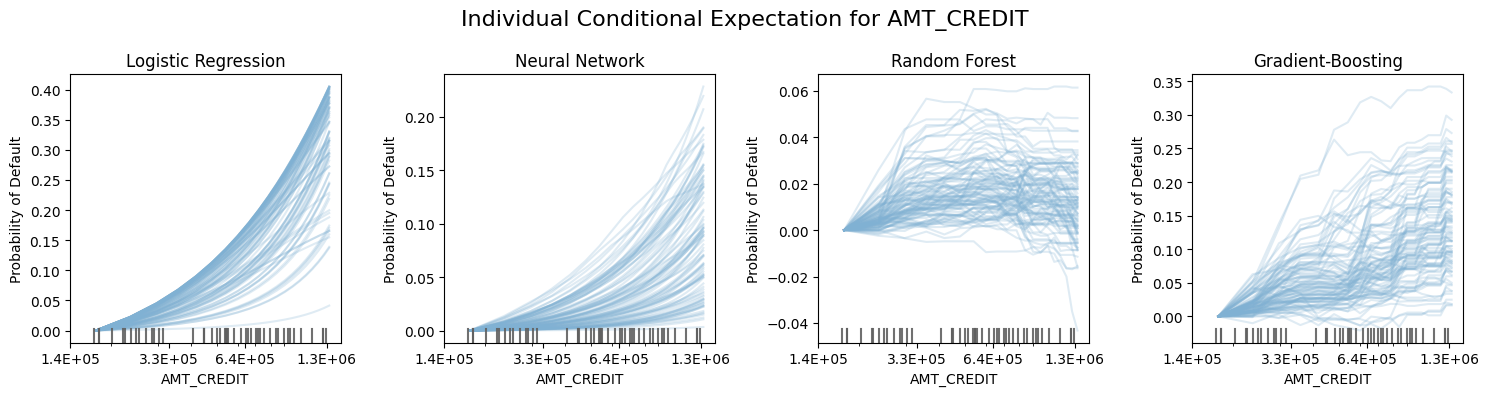

In [12]:
plot_ice(model_list, X_sample.head(100), "AMT_CREDIT")
plt.savefig("explainability_data/ice_credit.pdf", dpi = 300)

## SHAP and LIME

Ref for shap handling of categorical features: https://github.com/shap/shap/issues/397

In [14]:
model = joblib.load(f"../results/credit_models/{dataset_name}/{selected_fold}/LGBMClassifier.pkl")

In [127]:
Y_score = model.predict_proba(X_train)[:, 1]
threshold = ks_threshold(Y_train, Y_score)
shap_explainer = ShapPipelineExplainer(model, X_sample, method_explain="pred", threshold = threshold)
lime_explainer = LimePipelineExplainer(model, X_sample, method_explain="pred", threshold = threshold)

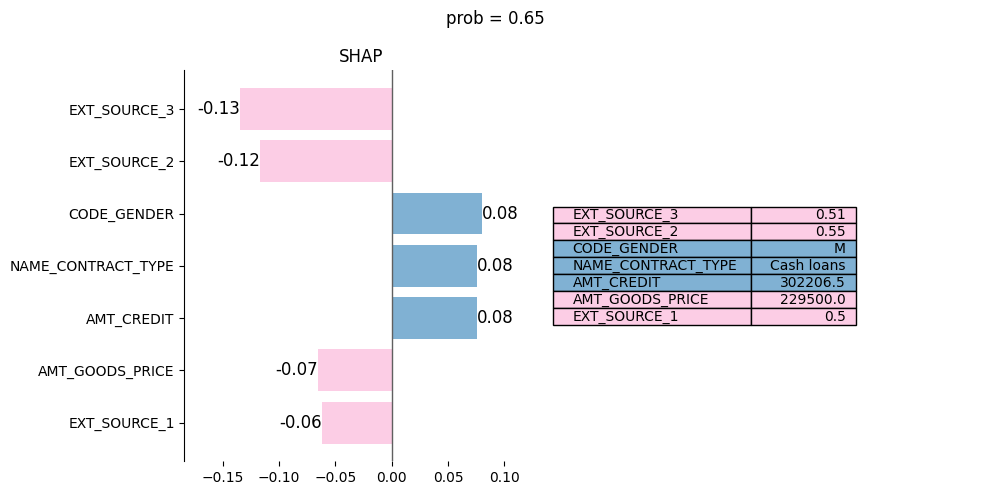

In [134]:
lime_explainer.plot_explanation(X_train.iloc[[2]])

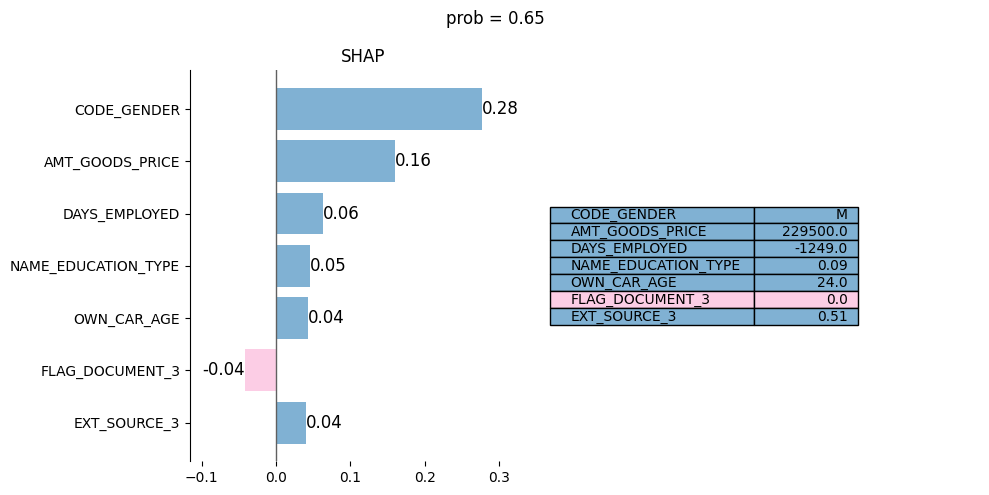

In [124]:
shap_explainer.plot_explanation(X_train.iloc[[2]])

In [17]:
def filter_columns(importances, top_k = 5):
    if len(importances) == 1:
        v = np.abs(importances.values[0])
        return importances.columns[v.argsort()[::-1]][0:top_k].tolist()
    else:
        v = np.mean(np.abs(importances.values), axis = 0)
        return importances.columns[v.argsort()[::-1]][0:top_k].tolist()
# for i in tqdm(range(X_train.shape[0])):
#     shap_explanation = shap_explainer(X_train.iloc[[i]])
#     lime_explanation = lime_explainer(X_train.iloc[[i]])
    
#     # check if CODE_GENDER is among the top 5 highest values
#     shap_important_features = filter_columns(shap_explanation)
#     lime_important_features = filter_columns(lime_explanation)
#     if "CODE_GENDER=F" in shap_important_features:
#         break
#     if "CODE_GENDER=F" in lime_important_features:
#         break

## MAPOCAM and DICE

### MAPOCAM

In [157]:
from cfmining.algorithms import MAPOCAM
from cfmining.action_set import ActionSet
from cfmining.criteria import PercentileChangesCriterion, PercentileCalculator, PercentileCriterion
from cfmining.predictors import LinearClassifier
import dice_ml

In [136]:
model = joblib.load(f"../results/credit_models/{dataset_name}/{selected_fold}/LogisticRegression.pkl")

In [164]:
X_preprocess = model[:-1].transform(X_train)
# add a very small noise to X_preprocess just to have different values
X_preprocess += np.random.normal(0, 1e-6, X_preprocess.shape)
predictor = LinearClassifier(model[-1], X_preprocess)
mutable_features = X_preprocess.columns.tolist()
action_set = ActionSet(X = X_preprocess)
coefs_ = model[-1].coef_[0]
for i, feat in enumerate(action_set):
    if not feat.name in mutable_features:
        feat.mutable = False
    
    direction = 1 if coefs_[i] < 0 else -1
    feat.flip_direction = 1
    feat.step_direction = direction
perc_calc = PercentileCalculator(action_set = action_set)

In [165]:
class WrapperClassifier:
    def __init__(self, classifier, target = 1):
        self.classifier = classifier
        self.target = target
        self.monotone = classifier.monotone
        self.threshold = classifier.threshold
        self.feat_importance = classifier.feat_importance

    def predict_proba(self, X):
        prob = self.classifier.predict_proba(X)
        if self.target == 0:
            return 1 - prob
        return prob
        
predictor_wrapper = WrapperClassifier(predictor, target = 0)

In [169]:
individual = model[:-1].transform(X_train.iloc[[6]]).values[0]

criteria = PercentileChangesCriterion(individual, perc_calc)
method = MAPOCAM(
    action_set,
    individual,
    predictor_wrapper,
    max_changes = 5,
    compare = criteria
)
method.fit()

In [208]:
def display_cfs(x, cfs, action_set, model):
    feature_names = [feat.name for feat in action_set]
    df = pd.DataFrame([x] + cfs, columns = feature_names)
    # give name to the index
    df.index = ["Original"] + [f"CF {i}" for i in range(len(cfs))]
    selected_columns = []
    for col in df.columns:
        if df[col].max() != df[col].min():
            selected_columns.append(col)

    # return to original scale
    scaled_features = model[2].transformers_[0][2]
    for feature in selected_columns:
        if feature in scaled_features:
            idx = scaled_features.index(feature)
            scaler = model[2].transformers_[0][1]
            mu = scaler.mean_[idx]
            sigma = scaler.scale_[idx]
            df[feature] = df[feature] * sigma + mu

    df = df[selected_columns]
    # calculate percentile change
    for col in selected_columns:
        feat_ = action_set[col]
        perc = feat_.percentile(df[col])
        perc -= perc[0]
        df[col+"_perc"] = perc
        df[col+"_perc"] = df[col+"_perc"].round(3)

        if df[col].max() < 1:
            df[col] = df[col].round(2)
        else:
            df[col] = df[col].round(0)
        df[col] = df[col].astype(str) + " (" + df[col+"_perc"].astype(str) + ")"

    return df[selected_columns]


In [209]:
display_cfs(individual, method.solutions, action_set, model)

,AMT_GOODS_PRICE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
Original,67500.0 (0.0),0.5 (0.0),0.05 (0.0),0.51 (0.0)
CF 0,206100.0 (0.0),0.5 (0.0),0.35 (0.122),0.6 (0.024)
CF 1,206100.0 (0.0),0.51 (0.001),0.35 (0.122),0.59 (0.022)
CF 2,67500.0 (0.0),0.5 (0.0),0.42 (0.154),0.64 (0.035)
CF 3,67500.0 (0.0),0.5 (0.0),0.58 (0.233),0.51 (0.0)


### Dice

In [210]:
import json

In [211]:
class Dice:
    """Wrapper function for Dice algorithm, fit expects an individual and can be called multiple times.


    Parameters
    ----------
    data : DataFrame
        Dataframe with model features
    Y : np.ndarray or pd.Series
        Classifier target
    model : GeneralClassifier
        Sklearn classifier
    n_cfs : int
        Number of counterfactuals to generate
    mutable_features: list
        List of features that can be used on conterfactuals
    sparsity_weight: float
        Parameter, weight for sparsity in optimization problem
    """

    def __init__(self, data, Y, model, n_cfs, mutable_features, sparsity_weight=0.2):
        self.total_CFs = n_cfs
        self.sparsity_weight = sparsity_weight
        self.mutable_features = mutable_features
        self.features = data.columns.tolist()
        dice_model = dice_ml.Model(
            model=model, backend="sklearn", model_type="classifier"
        )
        data_extended = data.copy()
        data_extended["target"] = Y
        dice_data = dice_ml.Data(
            dataframe=data_extended,
            continuous_features=data.columns.tolist(),
            outcome_name="target",
        )
        self.exp = dice_ml.Dice(dice_data, dice_model)

    def fit(self, individual):
        if type(individual) == np.ndarray:
            individual = pd.DataFrame(data=[individual], columns=self.features)
        dice_exp = self.exp.generate_counterfactuals(
            individual,
            total_CFs=self.total_CFs,
            desired_class="opposite",
            sparsity_weight=self.sparsity_weight,
            features_to_vary=self.mutable_features,
        )
        solutions = json.loads(dice_exp.to_json())["cfs_list"][0]
        self.solutions = [solution[:-1] for solution in solutions]
        if len(self.solutions) > 0:
            if isinstance(self.solutions[0], np.ndarray):
                self.solutions = [s.tolist() for s in self.solutions]
        return self

In [215]:
X_preprocess = model[:-1].transform(X_train)
mutable_features = X_preprocess.columns.tolist()
method = Dice(
    X_preprocess,
    Y_train,
    model[-1],
    n_cfs = 4,
    mutable_features = mutable_features
)
individual = model[:-1].transform(X_train.iloc[[6]]).values[0]
method.fit(individual)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:35<00:00, 35.35s/it]


In [216]:
display_cfs(individual, method.solutions, action_set, model)

,HOUSETYPE_MODE_1,AMT_GOODS_PRICE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_14,FLAG_DOCUMENT_17
Original,0.0 (0.0),67500.0 (0.0),1.0 (0.0),0.0 (0.0),0.0 (0.0)
CF 0,0.0 (0.0),67500.0 (0.0),1.0 (0.0),0.0 (0.0),0.8 (0.0)
CF 1,0.6 (0.519),2625849.0 (0.0),1.0 (0.0),0.0 (0.0),0.0 (0.0)
CF 2,0.0 (0.0),3012882.0 (0.0),1.0 (0.0),0.91 (0.0),0.0 (0.0)
CF 3,0.0 (0.0),2954245.0 (0.0),1.0 (0.0),0.0 (0.0),0.0 (0.0)
